In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3)

model.save('handwritten.h5')

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8647 - loss: 0.4624
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9644 - loss: 0.1131
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9786 - loss: 0.0702


In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

model = tf.keras.models.load_model('handwritten.h5')

loss,accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9634 - loss: 0.1187
0.10502762347459793
0.9684000015258789


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
This digit is probably a 2


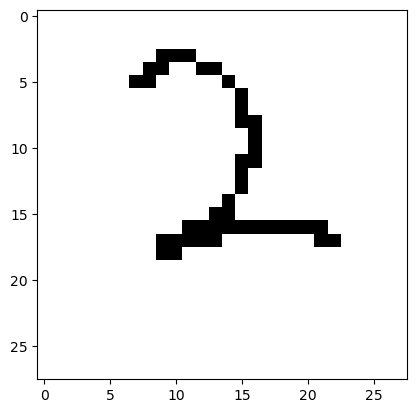

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This digit is probably a 3


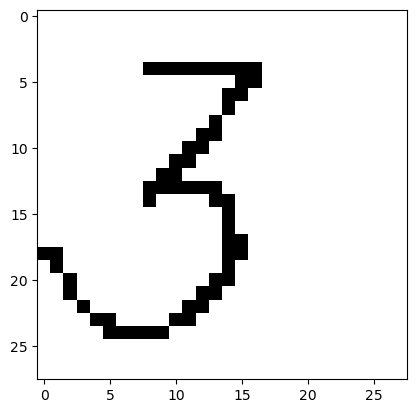

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This digit is probably a 6


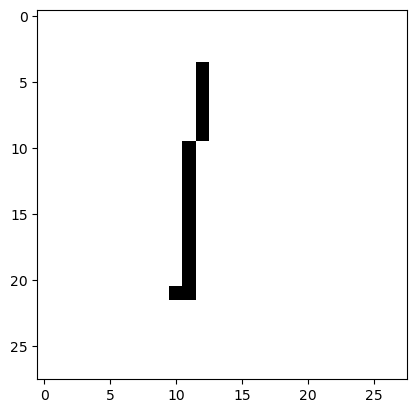

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
This digit is probably a 4


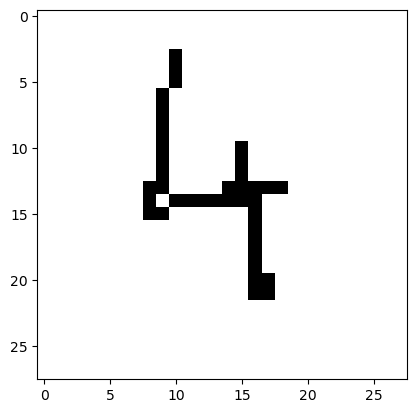

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This digit is probably a 8


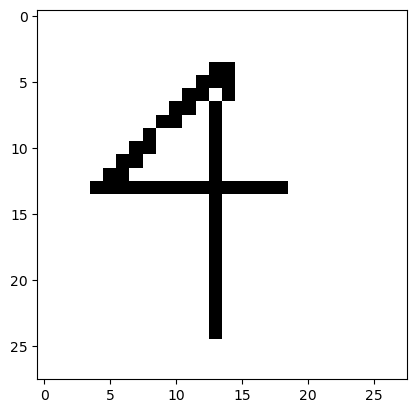

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This digit is probably a 5


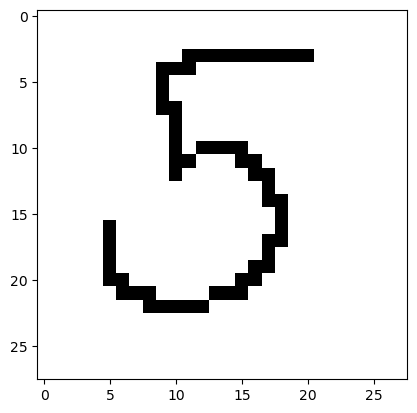

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
This digit is probably a 1


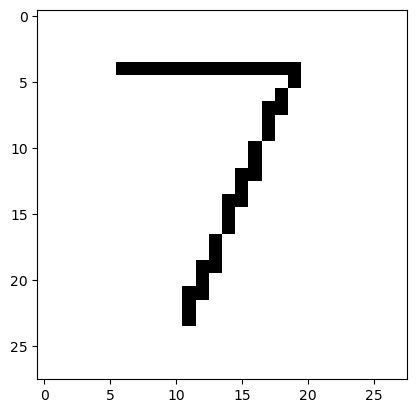

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This digit is probably a 2


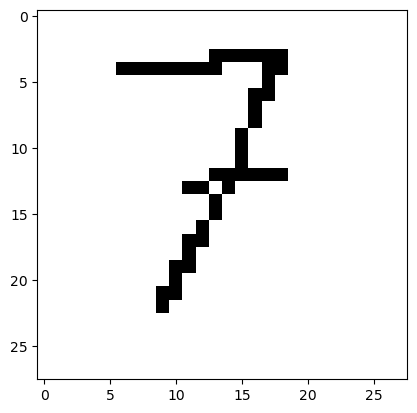

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This digit is probably a 7


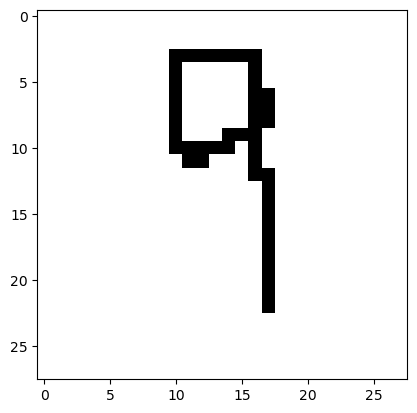

In [50]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

model = tf.keras.models.load_model('handwritten2.h5')

image_num = 1
while os.path.isfile(f"digits/digit{image_num}.png"):
    try:
        img = cv2.imread(f"digits/digit{image_num}.png")[:,:,0]
        img = np.invert(np.array([img]))
        prediction = model.predict(img)
        print(f"This digit is probably a {np.argmax(prediction)}")
        plt.imshow(img[0], cmap=plt.cm.binary)
        plt.show()
    except:
        print("error!")
    finally:
        image_num +=1

In [47]:
import fitz  # PyMuPDF
import cv2
import numpy as np
import re
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('handwritten4.keras')



# Function to convert PDF to images
def pdf_to_images(pdf_path):
    doc = fitz.open(pdf_path)
    images = []
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        pix = page.get_pixmap()
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
        images.append(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return images


# Function to filter red marks from an image
def filter_red_marks(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv_img, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    red_marks = cv2.bitwise_and(image, image, mask=red_mask)
    gray_marks = cv2.cvtColor(red_marks, cv2.COLOR_BGR2GRAY)
    return gray_marks


# Function to predict marks using the model
# Function to predict marks using the model
def predict_marks(image):
    # Ensure the image is not empty
    if image.size == 0:
        return 0  # Return 0 or some default value if the image is empty

    # Preprocess the image for the model
    img = cv2.resize(image, (28, 28))  # Resize to 28x28
    img = img.astype('float32') / 255.0  # Normalize
    # img = np.invert(img)  # Invert colors
    img = img.reshape(1, 28, 28)  # Reshape for the model input
    prediction = model.predict(img)

    return np.argmax(prediction)

# Function to extract and return marks
def extract_marks(image):
    # Extract each digit from the image and predict
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    marks = []
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        digit_img = image[y:y+h, x:x+w]  # Extract the digit

        # Convert the digit image to uint8 before prediction
        digit_img = cv2.normalize(digit_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        predicted_mark = predict_marks(digit_img)
        marks.append(predicted_mark)

    return marks



# Main function
def process_exam_copy(input_path):
    total_marks = 0
    all_marks = []  # To store marks from each page or image

    if input_path.lower().endswith('.pdf'):
        images = pdf_to_images(input_path)
    else:
        images = [cv2.imread(input_path)]

    for i, img in enumerate(images):
        red_marks_img = filter_red_marks(img)
        marks = extract_marks(red_marks_img)

        # Sum the predicted marks
        page_total = sum(marks)
        total_marks += page_total

        # Store and print marks for the current page/image
        all_marks.append(marks)
        print(f"Marks found on page {i + 1}: {marks}")

    print(f"Total Marks: {total_marks}")
    return total_marks


# Example usage
input_file = r'C:\Users\shiva\Downloads\SDL\Document_46_1.pdf'
total = process_exam_copy(input_file)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Marks found on page 1: [4, 3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Marks found on page 2: [2, 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Marks found on page 3: [2, 1, 1, 2, 2, 8, 1, 6, 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Marks found on page 4: [8, 3]
Total Marks: 50


In [21]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = tf.keras.utils.normalize(x_train, axis=1).reshape(-1, 28, 28, 1)  # Reshape for CNN
x_test = tf.keras.utils.normalize(x_test, axis=1).reshape(-1, 28, 28, 1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, validation_split=0.2, epochs=20, callbacks=[early_stopping])

model.save('handwritten2.h5')


Epoch 1/20


C:\Users\shiva\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8533 - loss: 0.6444 - val_accuracy: 0.9507 - val_loss: 0.2917
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9437 - loss: 0.3092 - val_accuracy: 0.9644 - val_loss: 0.2388
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9554 - loss: 0.2571 - val_accuracy: 0.9692 - val_loss: 0.2074
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9606 - loss: 0.2303 - val_accuracy: 0.9714 - val_loss: 0.1947
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9646 - loss: 0.2087 - val_accuracy: 0.9704 - val_loss: 0.1941
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9677 - loss: 0.1995 - val_accuracy: 0.9737 - val_loss: 0.1768
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9686 - loss: 0.1891 - val_accuracy: 0.9780 - val_loss: 0.1645
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9710 - loss: 0.18

In [46]:
import tensorflow as tf
from tensorflow.keras import layers

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape the data for CNN
x_train = tf.keras.utils.normalize(x_train, axis=1).reshape(-1, 28, 28, 1)
x_test = tf.keras.utils.normalize(x_test, axis=1).reshape(-1, 28, 28, 1)

# Build the model
model = tf.keras.models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    
    # Layer Group 1
    layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    # Layer Group 2
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    # Flatten before feeding into head
    layers.Flatten(),
    layers.Dense(units=64, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    layers.Dense(units=64, activation='leaky_relu'),
    layers.Dense(units=64, activation='leaky_relu'),
    layers.Dense(units=10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
model.fit(x_train, y_train, validation_split=0.2, epochs=20, callbacks=[early_stopping])

# Save the model
model.save('handwritten4.keras')


Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.8845 - loss: 0.3735 - val_accuracy: 0.9725 - val_loss: 0.1015
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9744 - loss: 0.0838 - val_accuracy: 0.9863 - val_loss: 0.0458
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9823 - loss: 0.0597 - val_accuracy: 0.9895 - val_loss: 0.0402
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9846 - loss: 0.0501 - val_accuracy: 0.9890 - val_loss: 0.0399
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9875 - loss: 0.0431 - val_accuracy: 0.9895 - val_loss: 0.0382
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9889 - loss: 0.0362 - val_accuracy: 0.9917 - val_loss: 0.0285
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9914 - loss: 0.0274 - val_accuracy: 0.9918 - val_loss: 0.0330
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9914 -

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis=1).reshape(-1, 28, 28, 1)  # Reshape for CNN
x_test = tf.keras.utils.normalize(x_test, axis=1).reshape(-1, 28, 28, 1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Try 0.0001 or 0.00001
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, validation_split=0.2, epochs=20, callbacks=[early_stopping])

model.save('handwritten3.h5')

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8419 - loss: 0.6572 - val_accuracy: 0.9534 - val_loss: 0.2695
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9473 - loss: 0.2878 - val_accuracy: 0.9645 - val_loss: 0.2249
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9608 - loss: 0.2348 - val_accuracy: 0.9712 - val_loss: 0.1913
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9646 - loss: 0.2056 - val_accuracy: 0.9678 - val_loss: 0.1897
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9696 - loss: 0.1873 - val_accuracy: 0.9698 - val_loss: 0.1804
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9719 - loss: 0.1733 - val_accuracy: 0.9751 - val_loss: 0.1649
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9728 - loss: 0.1679 - val_accuracy: 0.9728 - val_loss: 0.1697
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9724 -

In [35]:
import fitz  # PyMuPDF
import cv2
import numpy as np
import re
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('handwritten.h5')

# Function to convert PDF to images
def pdf_to_images(pdf_path):
    doc = fitz.open(pdf_path)
    images = []
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        pix = page.get_pixmap()
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
        images.append(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return images

# Function to filter red marks from an image
def filter_red_marks(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Adjusted lower and upper red HSV values for more specificity
    lower_red1 = np.array([0, 70, 50])  # Lower range for red
    upper_red1 = np.array([10, 255, 255])  # Upper range for lower red
    lower_red2 = np.array([170, 70, 50])  # Lower range for high red
    upper_red2 = np.array([180, 255, 255])  # Upper range for high red

    mask1 = cv2.inRange(hsv_img, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Apply morphological operations to enhance red marks
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)  # Close small holes
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)   # Remove small noise

    # Bitwise AND to extract red marks
    red_marks = cv2.bitwise_and(image, image, mask=red_mask)
    gray_marks = cv2.cvtColor(red_marks, cv2.COLOR_BGR2GRAY)

    return gray_marks

# Function to predict marks using the model
def predict_marks(image):
    # Ensure the image is not empty
    if image.size == 0:
        return 0  # Return 0 or some default value if the image is empty

    # Preprocess the image for the model
    img = cv2.resize(image, (28, 28))  # Resize to 28x28
    img = img.astype('float32') / 255.0  # Normalize
    img = img.reshape(1, 28, 28, 1)  # Reshape for the model input
    prediction = model.predict(img)

    return np.argmax(prediction)

# Function to extract and return marks
def extract_marks(image):
    # Extract each digit from the image and predict
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    marks = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        
        # Filter contours based on area to reduce noise
        if area > 40:  # You can adjust this threshold based on your images
            x, y, w, h = cv2.boundingRect(contour)
            digit_img = image[y:y+h, x:x+w]  # Extract the digit

            # Convert the digit image to uint8 before prediction
            digit_img = cv2.normalize(digit_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            
            predicted_mark = predict_marks(digit_img)
            marks.append(predicted_mark)

    return marks

# Main function
def process_exam_copy(input_path):
    total_marks = 0
    all_marks = []  # To store marks from each page or image

    if input_path.lower().endswith('.pdf'):
        images = pdf_to_images(input_path)
    else:
        images = [cv2.imread(input_path)]

    for i, img in enumerate(images):
        red_marks_img = filter_red_marks(img)
        marks = extract_marks(red_marks_img)

        # Sum the predicted marks
        page_total = sum(marks)
        total_marks += page_total

        # Store and print marks for the current page/image
        all_marks.append(marks)
        print(f"Marks found on page {i + 1}: {marks}")

    print(f"Total Marks: {total_marks}")
    return total_marks

# Example usage
input_file = r'C:\Users\shiva\Downloads\SDL\Document_46_1.pdf'
total = process_exam_copy(input_file)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Marks found on page 1: [8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Marks found on page 2: [2, 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Marks found on page 3: [6, 6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Marks found on page 4: [5, 3]
Total Marks: 35
